# 비지도학습 Autoencoder
### 출처 : 골빈해커의 3분 딥러닝 케라스맛,김성진 지음, 한빛미디어


## 1. 완전 연결 계층 AE 모델링

In [0]:
from keras import layers, models  # (Input, Dense), (Model)   # 서브패키지 import

class AE(models.Model):                                       # AE 모델링 수행하는 역할
    def __init__(self, x_nodes, z_dim):                # x_nodes : 입력 노드수, z_dim : 은닉 노드 수
        x_shape = (x_nodes,)                                  # x_shape은 입력노드수로 구성된 튜플
        x = layers.Input(shape=x_shape)                       # 입력 계층
        z = layers.Dense(z_dim, activation='relu')(x)         # 은닉 계층 z_dim에 따라 노드수 정해짐, 활성화 함수는 'relu'
        y = layers.Dense(x_nodes, activation='sigmoid')(z)    # 출력 계층, 활성화 함수는 'sigmoid' (<- 흑백이미지의 특성을 반영하기 위해, 색이 다양하면 선형함수가 더 적합)
        
        # 객체의 초기화 함수에서 초기 파라미터 저장
        super().__init__(x, y)                                

        self.x = x                # 입력 계층                            
        self.z = z                # 은닉 계층
        self.z_dim = z_dim        # 은닉 계층의 노드 수

        # AE 구조를 확정하고 컴파일 진행
        self.compile(optimizer = 'adam',
                     #optimizer='adadelta',        # 최적화 함수 : adadelta, (+ 모멘텀(가중치를 적절히 올리는 방식) = adam)
                     loss = 'mean_squared_error',
                     #loss='binary_crossentropy',  # loss = 손실함수(두 값의 거리차이) (MSE)
                     metrics=['accuracy'])        # 측정값 : 정확도
        

    # AE 중간에 있는 은닉 계층의 결과를 출력하도록 하는 별도의 부호화 모델 설정
    def Encoder(self):
        return models.Model(self.x, self.z)

    # 외부에서 새로운 부호화 데이터를 넣어 복호화 결과를 얻는 방법 제공
    def Decoder(self):
        z_shape = (self.z_dim,)
        z = layers.Input(shape=z_shape)       # 외부의 입력에 대응하는 새로운 입력을 만듬
        y_layer = self.layers[-1]             # 기존 은닉 계층을 사용하기에 self 사용, layers[-1]는 출력 계층을 의미
        y = y_layer(z)
        return models.Model(z, y)

## 2. 데이터 준비

In [0]:
from keras.datasets import mnist     # MNIST 불러오기
import numpy as np

(X_train, _), (X_test, _) = mnist.load_data()     # (_) : 레이블 정보를 받는 자리, AE는 사용하지 않기에 밑줄로 대체

# 0~255 중 하나로 표현되는 입력 이미지들의 값을 1 이하가 되도록 정규화
X_train = X_train.astype('float32')/255.  
X_test = X_test.astype('float32')/255.

# 형태를 3차원에서 2차원으로 변경, 첫 번째 인덱스 : 이미지 수, 두 번쨰 인덱스 : 2차원 이미지를 1차원으로 변경 후의 길이
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


## 3. 학습 효과 분석

### DATA Visualization

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 모델 학습 후 정보가 담긴 history 내용을 토대로 선 그래프를 그리는 함수 설정

def plot_acc(history, title=None):        # Accuracy(정확도) Visualization
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['acc'])        # accuracy
    plt.plot(history['val_acc'])    # validation accuracy
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_loss(history, title=None):     # Loss Visualization
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])           # loss
    plt.plot(history['val_loss'])       # validation
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


## 4. 완전 연결 계층 AE 동작 확인

In [0]:
def show_ae(autoencoder):

    # 각 모델의 인스턴스를 각각 생성
    encoder = autoencoder.Encoder()
    decoder = autoencoder.Decoder()

    # test 이미지로 입력, 출력 이미지 생성
    encoded_imgs = encoder.predict(X_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    # 화면에 이미지 표시하는 방법
    n = 10                                  # 표시할 이미지 갯수
    plt.figure(figsize=(20, 6))             # 보여줄 크기 지정

    for i in range(n):

        # 입력 이미지 (평가용 이미지, x_test)
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)   # 축이 보이지 않도록 함
        ax.get_yaxis().set_visible(False)

        # 압축된 형태 : 2차원의 이미지를 1차원 벡터로 압축하기에 부호화된 정보를 1차원 그래프로 표시 (x축 : 36개 정보)
        ax = plt.subplot(3, n, i + 1 + n)
        plt.stem(encoded_imgs[i].reshape(-1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # 결과 이미지(복호화 된 이미지)
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## 5. 학습 및 성능 평가

In [0]:
def main():             # AE main 함수 설정
    
    # AE 모델 인스턴스 정의
    x_nodes = 784       
    z_dim = 36          # 이미지가 784에서 36으로 압축됨 

    # AE 함수 실행
    autoencoder = AE(x_nodes, z_dim)

    # 학습 실행
    history = autoencoder.fit(X_train, X_train,       # 입력, 출력을 동일하게 설정
                              epochs=10,              # 10회 학습
                              batch_size=256,         # 1회 배치 마다 256개 프로세스 보내도록 설정
                              shuffle=True, 
                              validation_data=(X_test, X_test)) # 성능 평가 데이터


    # Visualization
    plot_acc(history, '(a) Accuracy')  # 학습 경과에 따른 정확도 변화 추이
    plt.show()
    plot_loss(history, '(b) Loss')     # 학습 경과에 따른 손실값 변화 추이
    plt.show()

    # AE 동작확인
    show_ae(autoencoder)
    plt.show()





Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 6s 96us/step - loss: 0.0790 - acc: 0.0088 - val_loss: 0.0470 - val_acc: 0.0094
Epoch 2/10
60000/60000 [==============================] - 1s 18us/step - loss: 0.0398 - acc: 0.0102 - val_loss: 0.0332 - val_acc: 0.0093
Epoch 3/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0298 - acc: 0.0102 - val_loss: 0.0263 - val_acc: 0.0100
Epoch 4/10
60000/60000 [==============================] - 1s 20us/step - loss: 0.0244 - acc: 0.0100 - val_loss: 0.0219 - val_acc: 0.0091
Epoch 5/10
60000/60000 [==============================] - 1s 20us/step - loss: 0.0209 - acc: 0.0100 - val_loss: 0.0190 - val_acc: 0.0103
Epoch 6/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0184 - acc: 0.0108 - val_loss: 0.0170 - val_acc: 0.0109
Epoch 7/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0167 - acc: 0.0106 - val_loss: 0.0156 

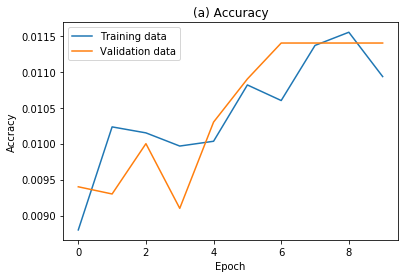

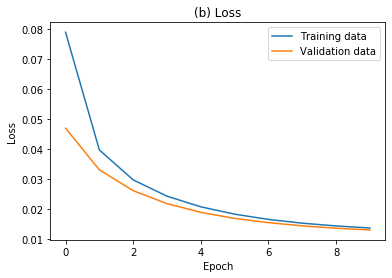

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


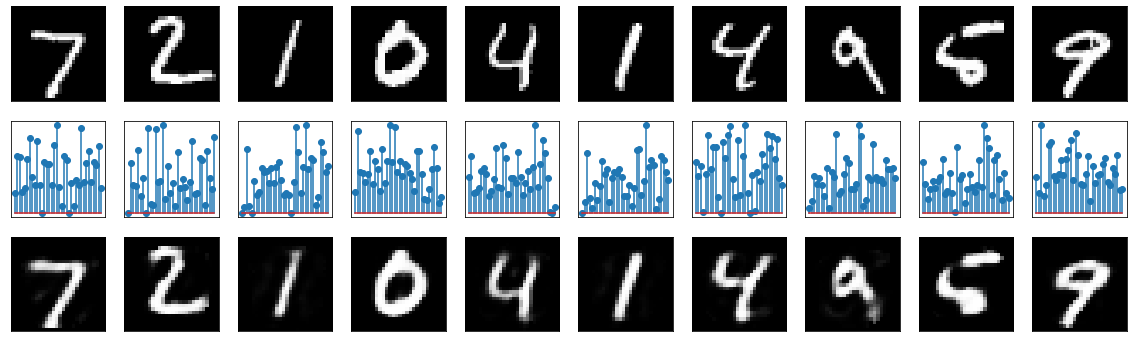

In [0]:
# main 함수 실행
if __name__ == '__main__':
    main()